In [62]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.functions import hour
import matplotlib.pyplot as plt

In [6]:
spark = SparkSession.builder \
        .appName("NYC Taxi Analysis") \
        .config("spark.driver.bindAddress", "127.0.0.1") \
        .getOrCreate()

25/01/29 16:04:42 WARN SparkContext: Another SparkContext is being constructed (or threw an exception in its constructor). This may indicate an error, since only one SparkContext should be running in this JVM (see SPARK-2243). The other SparkContext was created at:
org.apache.spark.api.java.JavaSparkContext.<init>(JavaSparkContext.scala:58)
java.base/jdk.internal.reflect.NativeConstructorAccessorImpl.newInstance0(Native Method)
java.base/jdk.internal.reflect.NativeConstructorAccessorImpl.newInstance(NativeConstructorAccessorImpl.java:75)
java.base/jdk.internal.reflect.DelegatingConstructorAccessorImpl.newInstance(DelegatingConstructorAccessorImpl.java:53)
java.base/java.lang.reflect.Constructor.newInstanceWithCaller(Constructor.java:502)
java.base/java.lang.reflect.Constructor.newInstance(Constructor.java:486)
py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:247)
py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:374)
py4j.Gateway.invoke(Gateway.java:238)
py4j.command

## Data Loading

In [68]:
# Todo : 여러 달 또는 년도 데이터 합치기

In [15]:
df = spark.read.parquet("data/yellow_tripdata_2024-11.parquet")

In [16]:
df

DataFrame[VendorID: int, tpep_pickup_datetime: timestamp_ntz, tpep_dropoff_datetime: timestamp_ntz, passenger_count: bigint, trip_distance: double, RatecodeID: bigint, store_and_fwd_flag: string, PULocationID: int, DOLocationID: int, payment_type: bigint, fare_amount: double, extra: double, mta_tax: double, tip_amount: double, tolls_amount: double, improvement_surcharge: double, total_amount: double, congestion_surcharge: double, Airport_fee: double]

## Data Cleaning

### 결측치 제거

In [17]:
df.count()

3646369

In [19]:
df = df.dropna()
df.count()

3272695

### 비정상적인 값(음수의 여행시간 또는 거리) 필터링

In [35]:
# 음수의 거리를 움직인 행의 개수
df[df['trip_distance'] < 0].count()

0

In [36]:
# 택시 탑승 시간 계산
df = df.withColumn(
    "trip_duration",
    (F.unix_timestamp("tpep_dropoff_datetime") - F.unix_timestamp("tpep_pickup_datetime"))
)

In [37]:
df[df['trip_duration'] < 0].count()

869

In [38]:
df = df.filter(df['trip_duration'] >= 0)
df.count()

3271826

## Calculation of Metrics

In [57]:
# Calculate the average trip duration
avg_trip_duration = df.agg({"trip_duration": "avg"}).collect()[0][0]
print(f"Average Trip Duration: {avg_trip_duration} sec")

Average Trip Duration: 1065.5371566214096 sec


In [59]:
# Calculate the average trip distance
avg_trip_distance = df.agg({"trip_distance": "avg"}).collect()[0][0]
print(f"Average Trip Distance: {avg_trip_distance} km")

Average Trip Distance: 3.3046252429070293 km


## Peak Hours Identification

+----+------+
|hour| count|
+----+------+
|  18|235533|
|  17|225113|
|  16|215703|
|  15|209833|
|  19|202571|
|  14|201219|
|  21|189497|
|  13|185952|
|  20|185402|
|  12|179584|
|  22|171410|
|  11|165401|
|  10|152631|
|   9|134995|
|  23|128876|
|   8|114424|
|   0| 88093|
|   7| 82681|
|   1| 62094|
|   6| 40595|
+----+------+
only showing top 20 rows



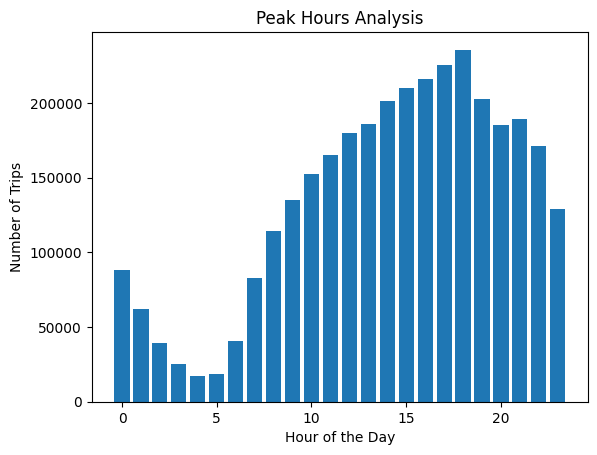

In [73]:
# Identify the peak hours for taxi usage.
df = df.withColumn("hour", hour("tpep_pickup_datetime"))
peak_hours = df.groupBy("hour").count().orderBy("count", ascending=False)
peak_hours.show()

peak_hours_pd = peak_hours.toPandas()
plt.bar(peak_hours_pd['hour'], peak_hours_pd['count'])
plt.xlabel('Hour of the Day')
plt.ylabel('Number of Trips')
plt.title('Peak Hours Analysis')
plt.show()

## Weather Condition Analysis

In [72]:
# Analyze the effect of weather conditions on taxi demand. 
# Use additional datasets if necessary to obtain weather information for the corresponding time periods.
# Todo : 택시 수요와 날씨 조건(기온, 강수량) 간의 상관관계 분석


## Output

In [71]:
# Todo : 계산된 지표와 분석 결과, 시각화된 그래프가 파일로 저장(CSV, Parquet)